In [200]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (12, 6)

In [201]:
import gpflow
import tensorflow as tf

# load test data

In [202]:
tmpx = np.load("test_eim.npy")
x = tmpx[:,0][:,np.newaxis]
y = tmpx[:,1:]

In [203]:
names = ['IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'SEOBNRv4_opt']

In [204]:
tmpx = np.load("test_eim_NR.npy")
nrx = tmpx[:,0][:,np.newaxis]
nry = tmpx[:,1][:,np.newaxis]

In [205]:
x.shape

(18, 1)

In [206]:
y.shape

(18, 4)

In [207]:
plt.figure()
plt.scatter(x, y[:,0])
plt.scatter(x, y[:,1])
plt.scatter(nrx, nry)

In [208]:
# make one long array for all data
xall = np.stack([x for i in range(len(names))])
xall = np.squeeze(xall).reshape(-1)

xall = np.concatenate((xall, nrx[:,0]))[:,np.newaxis]


In [209]:
xall.shape

(78, 1)

In [210]:
yall = np.stack([y[:,i] for i in range(len(names))])
yall = yall.reshape(-1)
yall = np.concatenate((yall, nry[:,0]))[:,np.newaxis]

In [211]:
yall.shape

(78, 1)

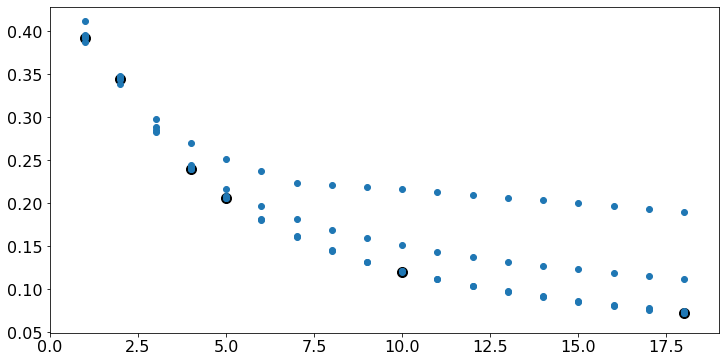

In [212]:
plt.figure()
plt.plot(xall, yall, 'o')
plt.scatter(nrx, nry, c='k', s=100)

# fitting functions

In [213]:
def fit_gp(X, Y):
    k = gpflow.kernels.Matern52()
#     k = gpflow.kernels.RBF()
    m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
    m.likelihood.variance.assign(0.01)
    m.kernel.lengthscales.assign(0.3)
    # by default using the L-BFGS-B
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

    return m

In [214]:
def plot_gpr(X, y, gp):
    
    xx = np.linspace(1, 18, 1000).reshape(-1, 1)  # test points must be of shape (N, D)
    
    mean, var = gp.predict_f(xx)
    
    plt.figure()
    plt.plot(X, y,' go',markerfacecolor='none', label='data')

    plt.plot(xx, mean, "C0", lw=2)
    plt.fill_between(
        xx[:, 0],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color="C0",
        alpha=0.2,
    )

    
#     ## generate 10 samples from posterior
#     tf.random.set_seed(1)  # for reproducibility
#     samples = gp.predict_f_samples(xx, 10)  # shape (10, 100, 1)
#     plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
    
    
    plt.legend()

In [215]:
def fit_and_plot(X, y):
    gp = fit_gp(X, y)
    plot_gpr(X, y, gp)
    return gp

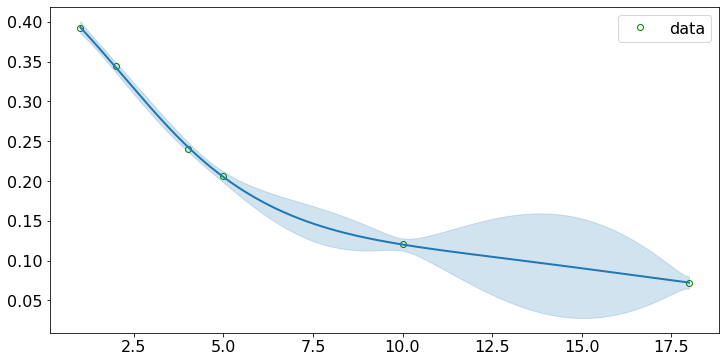

In [216]:
# GPR NR
nr_gp = fit_and_plot(nrx, nry)

working: IMRPhenomB
working: IMRPhenomC
working: IMRPhenomD
working: SEOBNRv4_opt


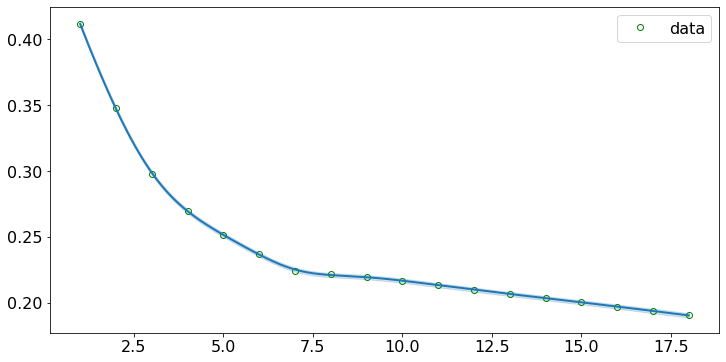

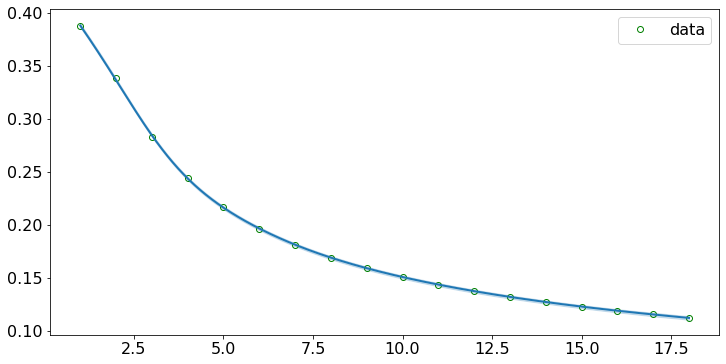

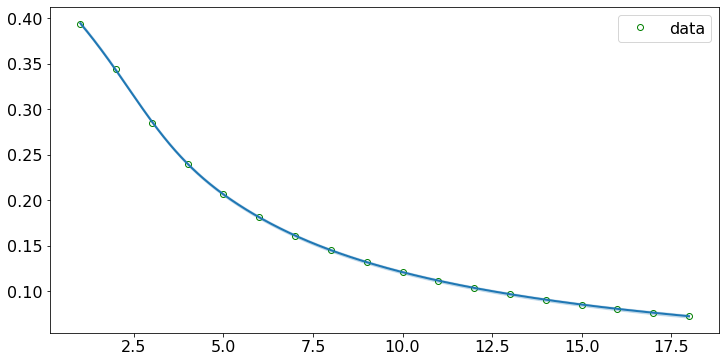

In [217]:
gps = {}
for i, name in enumerate(names):
    # GPR models
    print(f"working: {name}")
    gps.update({name:fit_and_plot(x, y[:,i][:,np.newaxis])})

# fitting all at same time?

In [218]:
# GPR all
all_gp = fit_and_plot(xall, yall)